Saving PCA variance plot for car data
Saving PCA contribution plot for car data
Saving PCA plot for car data
Saving PCA variance plot for customer data
Saving PCA contribution plot for customer data
Saving PCA plot for customer data
Evaluating Car Data Clustering Performance...
Evaluating Customer Data Clustering Performance...


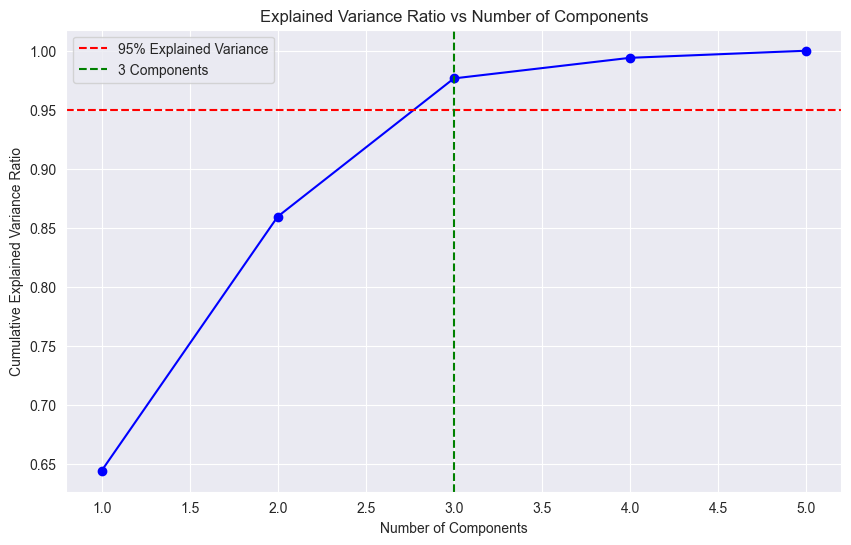

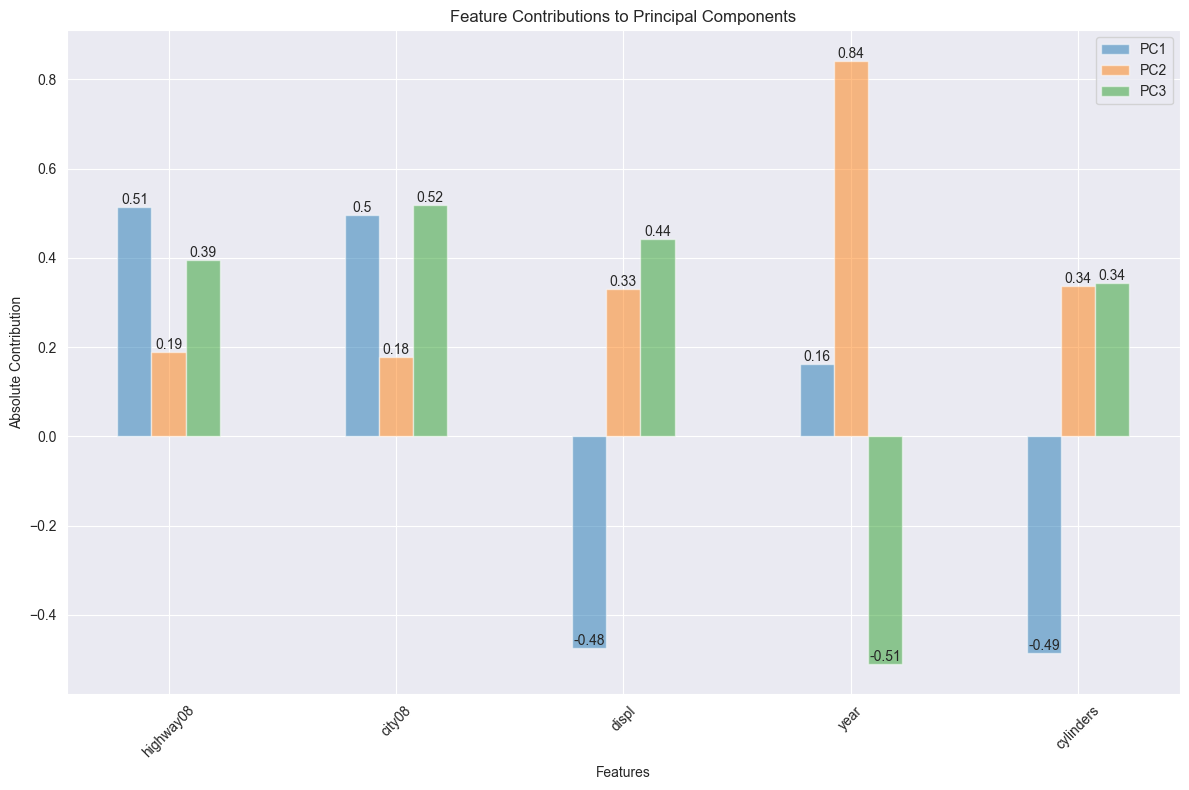

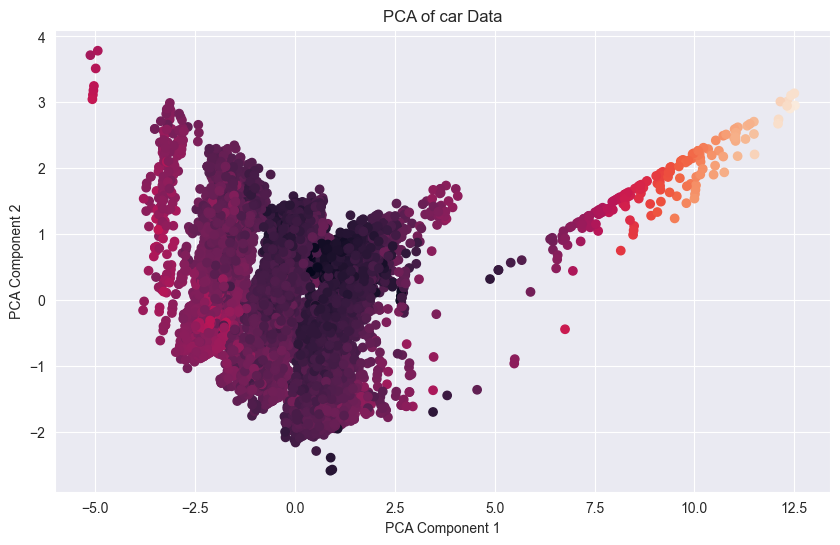

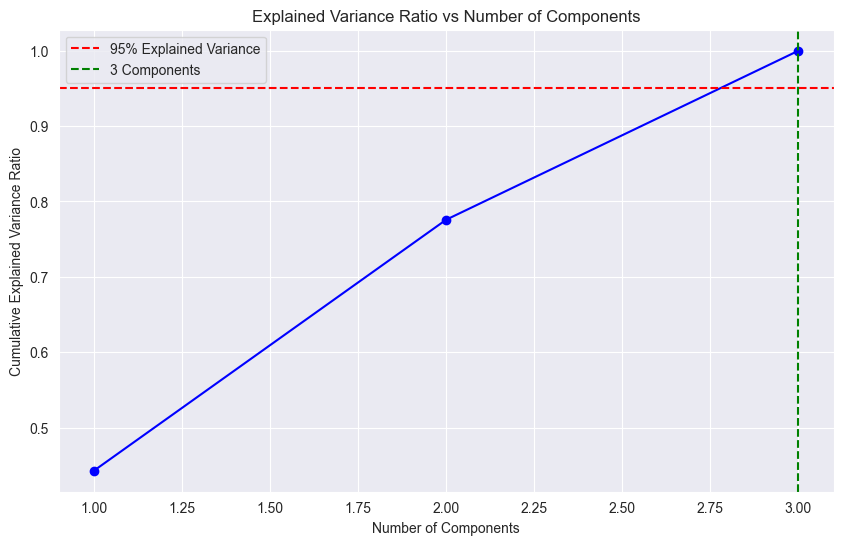

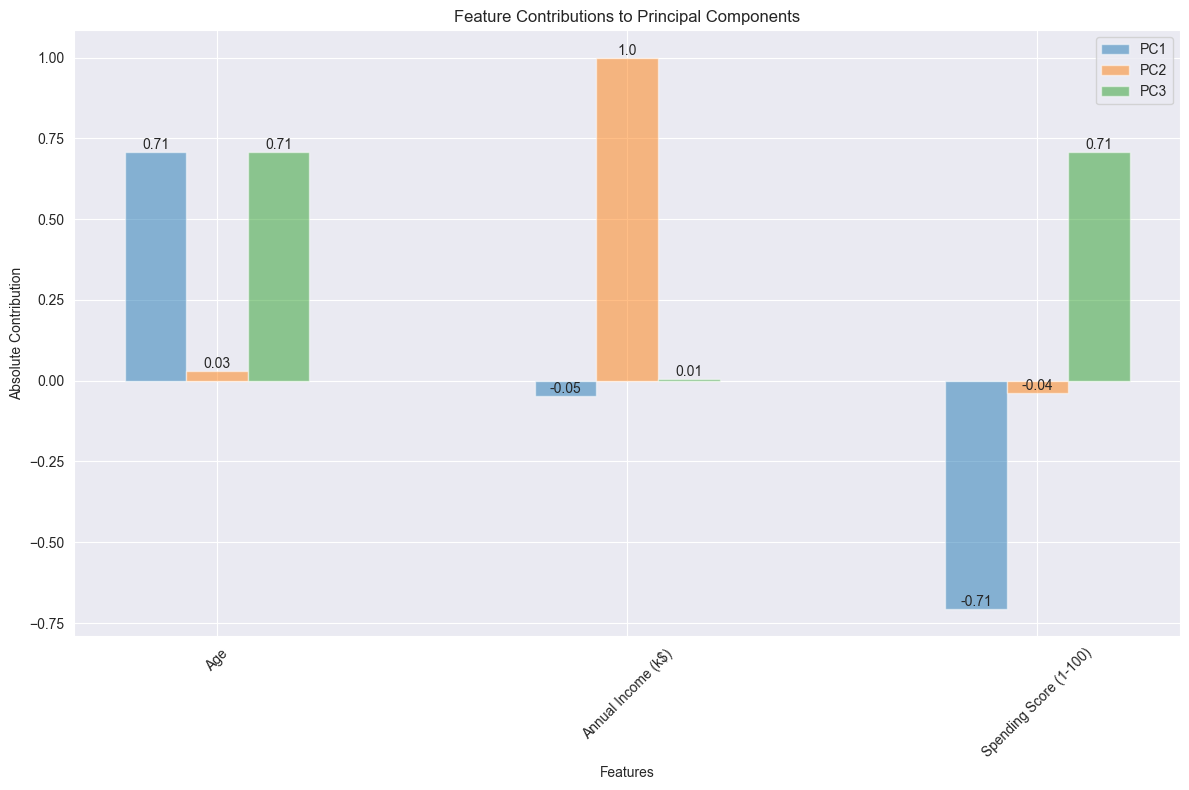

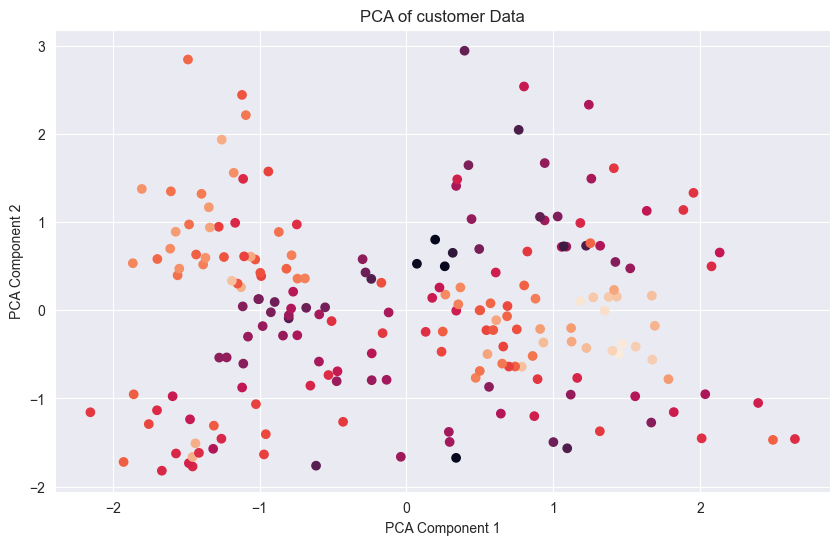

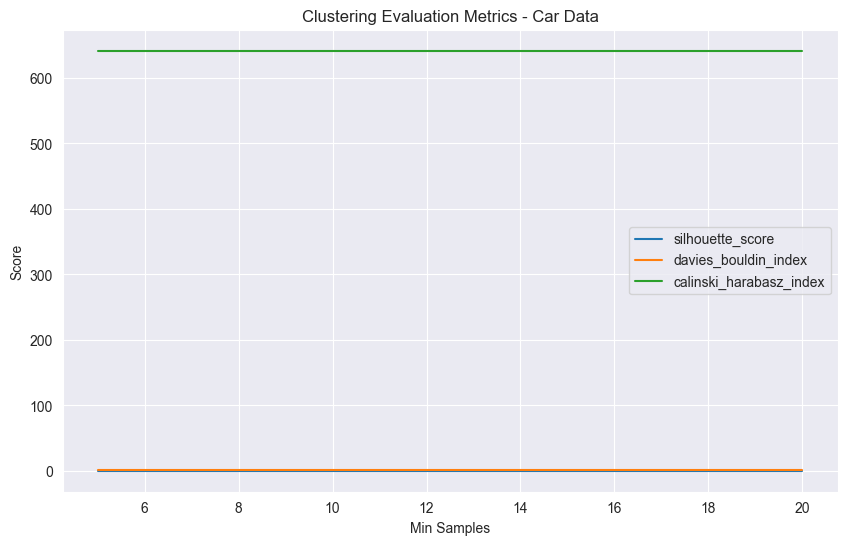

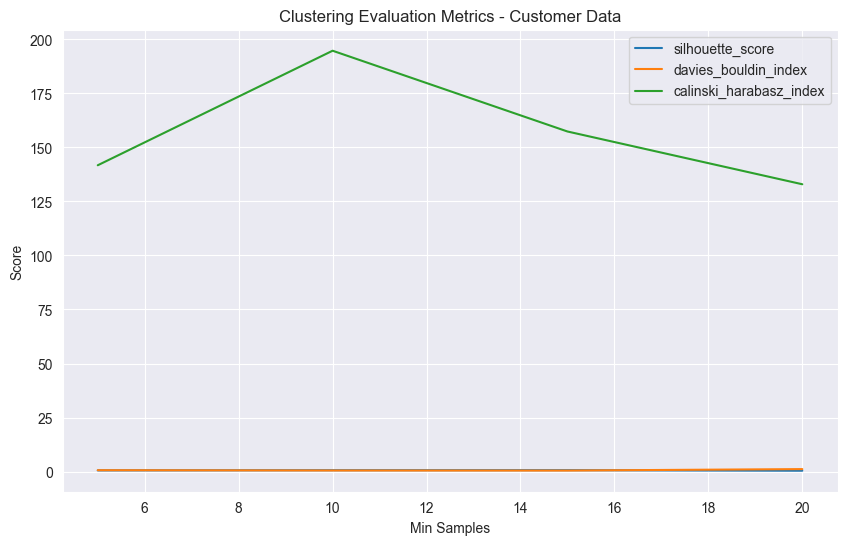

Car Data Clustering Metrics:
   silhouette_score  davies_bouldin_index  calinski_harabasz_index  \
0          0.389082              1.233197               641.287593   
1          0.389082              1.233197               641.287593   
2          0.389082              1.233197               641.287593   
3          0.389082              1.233197               641.287593   

   min_samples  
0            5  
1           10  
2           15  
3           20  

Customer Data Clustering Metrics:
   silhouette_score  davies_bouldin_index  calinski_harabasz_index  \
0          0.546187              0.637564               141.741335   
1          0.627342              0.506551               194.744310   
2          0.652614              0.470556               157.369434   
3          0.394985              1.144308               132.952634   

   min_samples  
0            5  
1           10  
2           15  
3           20  
Visualizing Best Clustering for Car Data...


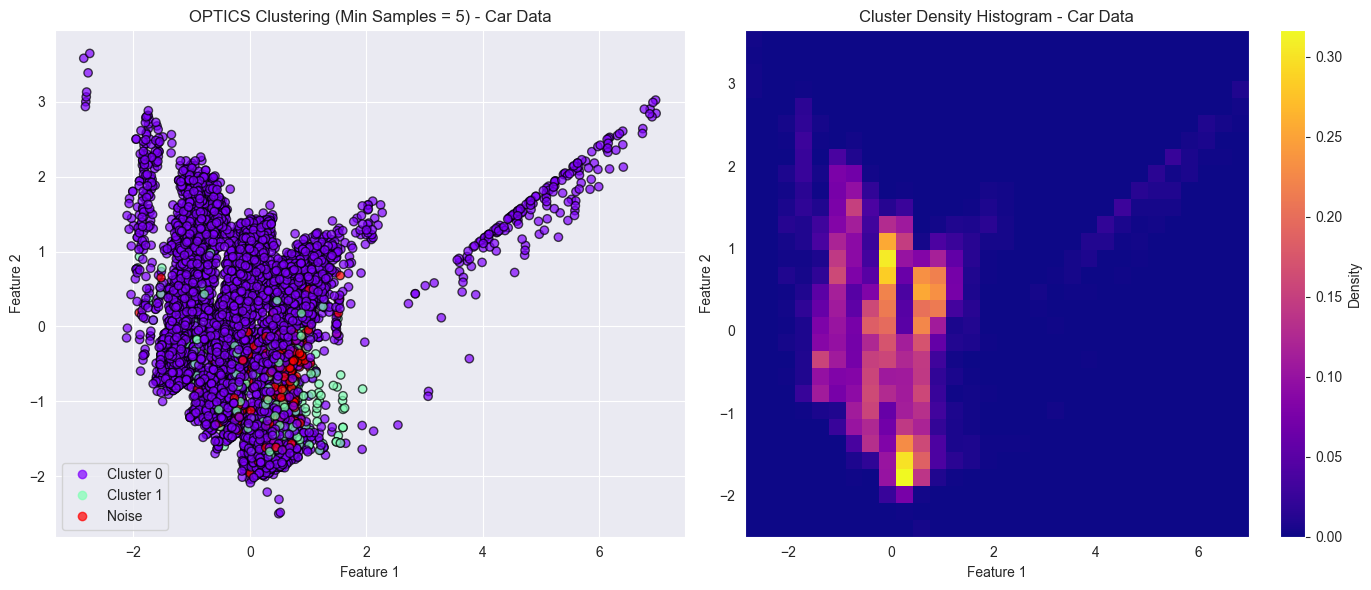

Visualizing Best Clustering for Customer Data...


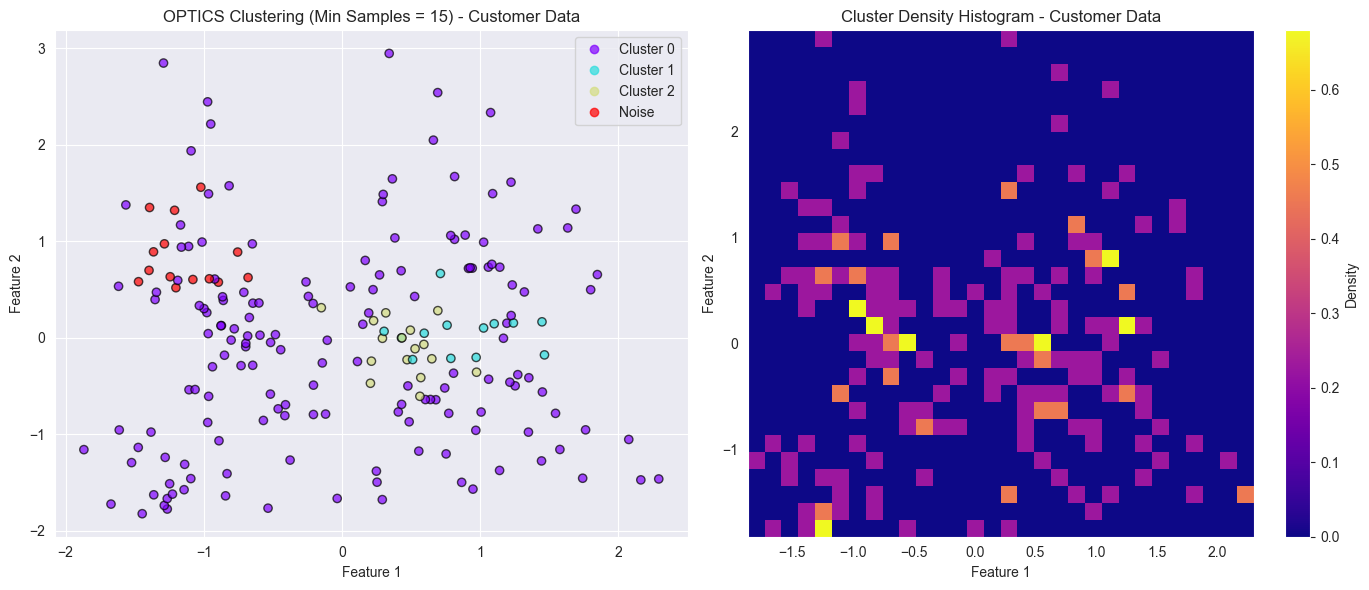

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from src.prep import Prep

np.random.seed(47)

# Load and prepare data
prep = Prep(output_pca=True)
car_data = prep.prep_car
customer_data = prep.prep_customer

# Standardizing the data to improve clustering performance
scaler = StandardScaler()
car_data = pd.DataFrame(scaler.fit_transform(car_data), columns=car_data.columns)
customer_data = pd.DataFrame(scaler.fit_transform(customer_data), columns=customer_data.columns)

def evaluate_clustering_metrics(data, labels):
    """
    Compute clustering evaluation metrics.
    """
    valid_labels = labels[labels != -1]
    data_filtered = data.iloc[labels != -1]
    
    if len(set(valid_labels)) > 1:
        silhouette = silhouette_score(data_filtered, valid_labels)
        davies_bouldin = davies_bouldin_score(data_filtered, valid_labels)
        calinski_harabasz = calinski_harabasz_score(data_filtered, valid_labels)
    else:
        silhouette, davies_bouldin, calinski_harabasz = -1, -1, -1
    
    return {
        'silhouette_score': silhouette,
        'davies_bouldin_index': davies_bouldin,
        'calinski_harabasz_index': calinski_harabasz
    }

def apply_optics_clustering(data, min_samples=5, xi=0.05, min_cluster_size=0.05):
    """
    Apply OPTICS clustering and return labels.
    """
    clustering = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    clustering.fit(data)
    return clustering.labels_

def plot_metric_curves(metrics_df, title):
    plt.figure(figsize=(10, 6))
    for metric in ['silhouette_score', 'davies_bouldin_index', 'calinski_harabasz_index']:
        plt.plot(metrics_df['min_samples'], metrics_df[metric], label=metric)
    plt.xlabel('Min Samples')
    plt.ylabel('Score')
    plt.title(f'Clustering Evaluation Metrics - {title}')
    plt.legend()
    plt.show()

def evaluate_multiple_clusters(data, min_samples_range):
    """
    Evaluate clustering for different min_samples values.
    """
    results = []
    
    for min_samples in min_samples_range:
        labels = apply_optics_clustering(data, min_samples=min_samples)
        metrics = evaluate_clustering_metrics(data, labels)
        metrics['min_samples'] = min_samples
        results.append(metrics)
    
    return pd.DataFrame(results)

# Evaluate clustering performance
min_samples_range = [5, 10, 15, 20]
print("Evaluating Car Data Clustering Performance...")
car_metrics_df = evaluate_multiple_clusters(car_data, min_samples_range)
print("Evaluating Customer Data Clustering Performance...")
customer_metrics_df = evaluate_multiple_clusters(customer_data, min_samples_range)

# Plot metric curves
plot_metric_curves(car_metrics_df, 'Car Data')
plot_metric_curves(customer_metrics_df, 'Customer Data')

# Display metrics table
print("Car Data Clustering Metrics:")
print(car_metrics_df)
print("\nCustomer Data Clustering Metrics:")
print(customer_metrics_df)

# Identify best min_samples based on Silhouette Score
best_car_params = car_metrics_df.loc[car_metrics_df['silhouette_score'].idxmax(), 'min_samples']
best_customer_params = customer_metrics_df.loc[customer_metrics_df['silhouette_score'].idxmax(), 'min_samples']

def visualize_best_clustering(data, best_min_samples, title):
    """
    Visualize the best clustering results using a scatter plot and histogram density.
    """
    labels = apply_optics_clustering(data, min_samples=best_min_samples)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Scatter plot of clusters
    scatter = axes[0].scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='rainbow', edgecolor='k', alpha=0.7)
    axes[0].set_title(f"OPTICS Clustering (Min Samples = {best_min_samples}) - {title}")
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")
    legend_labels = set(labels)
    axes[0].legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {l}' if l != -1 else 'Noise' for l in legend_labels])

    # Histogram grid density
    axes[1].hist2d(data.iloc[:, 0], data.iloc[:, 1], bins=30, cmap='plasma', density=True)
    axes[1].set_title(f"Cluster Density Histogram - {title}")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")
    plt.colorbar(axes[1].collections[0], ax=axes[1], label='Density')

    plt.tight_layout()
    plt.show()

print("Visualizing Best Clustering for Car Data...")
visualize_best_clustering(car_data, best_car_params, 'Car Data')
print("Visualizing Best Clustering for Customer Data...")
visualize_best_clustering(customer_data, best_customer_params, 'Customer Data')
